In [ ]:
!pip install tb

In [ ]:
!pip install attrdict

In [ ]:
!pip install d3rlpy

In [3]:
import os
import re

import torch
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
import random
import torchvision.utils as vutils
import argparse
import math
import cv2
from matplotlib import pyplot as plt

from torchsummary import summary

from abc import abstractmethod

# Set random seed for reproducibility
seed = 1141
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:8" if (torch.cuda.is_available()) else "cpu")

Random Seed:  1141


In [31]:
train_ds = EdgesDataset(config=config)

dataloader = DataLoader(train_ds, config.parameters.dreamer.batch_size, shuffle=False)

In [41]:
train_ds[0]

(tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[1., 0., 1.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 1., 1., 1.]],
 
         [[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 1., 1., 1.],
       

In [2]:
from encoder import Encoder

In [3]:
model = Encoder(config)

In [6]:
model.to('cuda')

Encoder(
  (_convs): Sequential(
    (0): Conv2dSame(2, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2dSame(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2dSame(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2dSame(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
)

In [2]:
from decoder import Decoder

In [3]:
model = Decoder(config)

In [4]:
model.to('cuda')

Decoder(
  (_conv_transes): Sequential(
    (0): ConvTranspose2dSame(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2dSame(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2dSame(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2dSame(8, 2, kernel_size=(3, 3), stride=(2, 2))
    (10): Sigmoid()
  )
)

In [1]:
from vae import EdgeEntropyVAE

In [3]:
model = EdgeEntropyVAE(config, 0.5)

In [4]:
model

EdgeEntropyVAE(
  (encoder): Encoder(
    (_convs): Sequential(
      (0): Conv2dSame(2, 8, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2dSame(8, 16, kernel_size=(3, 3), stride=(2, 2))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2dSame(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
      (9): Conv2dSame(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): Decoder(
    (_conv_transes): Sequential(
      (0): ConvTranspose2dSame(64, 32, kernel_size=(3, 3), stride=(2, 2))
      (

In [10]:
model.reparameterize(torch.Tensor([0]), torch.Tensor([2]))

tensor([-0.3455])

In [15]:
torch.stack([torch.Tensor([[[0,1],[0,1]]]),torch.Tensor([[[1,1],[1,1]]])]).shape

torch.Size([2, 1, 2, 2])

In [54]:
import re
import cv2

def extract_metadata(fpath):
    
    with open(fpath, 'r') as file:
        info = file.read().rstrip()
        
    info_splited = info.split('_')
    
    timestep = int(info_splited[0])
    reward = int(info_splited[1])
    player_x = int(info_splited[2])
    player_y = int(info_splited[3])
    
    
    movements = info_splited[4].split(';')[:-1]
    
    walk_distance = jump_height = jump_true = 0
    
    for i in range(len(movements)):
        
        movement_list = [int(x) for x in list(movements[i])]
        
        if movement_list[0] == 1:
            walk_distance -= 1
            
        if movement_list[1] == 1:
            walk_distance += 1
        
        if movement_list[2] == 1:
            jump_true = 1
        
        # Если jumpt_true == 0, то не делаем ничего
        if (movement_list[3] == 0) and (jump_true == 1):
            jump_height += 1
        elif (movement_list[3] == 1) and (jump_true == 1):
            jump_height += 1
            jump_true = 0
    
    return timestep, reward, player_x, player_y, walk_distance, jump_height

def load_img(seed, timestep, config):
    
    image_path_1 = config.parameters.edges_dataset.data_root + f'/screenshots0000_{seed}/{timestep}.png'
    image_path_2 = re.sub(r'/screenshots/', r'/screenshots_add/', image_path_1)

    metadata_path = image_path_2[:-3] + 'txt'

    timestep, reward, player_x, player_y, walk_distance, jump_height = extract_metadata(metadata_path)

    if timestep < 7668:
        timestep_next = timestep + 6
        terminal = False
    else:
        terminal = True

    # do your magic here
    # флаг 0 = читаем черно-белое изображение
    img1 = cv2.imread(image_path_1, 0)
    img2 = cv2.imread(image_path_2, 0)

    img_full1 = transform_img(img1, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot, aperture_size=self.config.aperture_size)
    img_full2 = transform_img(img2, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot, aperture_size=self.config.aperture_size)

    img_part1 = transform_img(img1, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot_part, part_size=self.config.part_size, player_x=player_x, player_y=player_y, aperture_size=self.config.aperture_size)
    img_part2 = transform_img(img2, dim=[self.config.image_size, self.config.image_size], zero_screenshot=self.zero_screenshot_part, part_size=self.config.part_size, player_x=player_x, player_y=player_y, aperture_size=self.config.aperture_size)

    sample_full = cv2.merge([img_full1, img_full2])
    sample_part = cv2.merge([img_part1, img_part2])
    
    return transforms.ToTensor()(sample_full), transforms.ToTensor()(sample_part), timestep, (player_x, player_y), (walk_distance, jump_height), reward, terminal

In [55]:
load_img(359803652, 12, config)

NameError: name 'transform_img' is not defined

In [3]:
train_ds = EdgesDataset(config=config)

dataloader = DataLoader(train_ds, config.parameters.dreamer.batch_size, shuffle=False)

In [4]:
seeds = get_seed_list(config.parameters.edges_dataset.data_root)

In [6]:
observations, actions, rewards, terminals = train_ds.load_episodes(seeds)

In [7]:
print(observations.shape, actions.shape, rewards.shape, terminals.shape)

(12770, 4, 64, 64) (12770, 2) (12770,) (12770,)


In [8]:
from d3rlpy.dataset import MDPDataset

dataset = MDPDataset(observations, actions, rewards, terminals, discrete_action=False)

In [16]:
dataset.dump('MDPdataset_SMF_' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

In [13]:
encoder = Encoder(config).to(device)

In [15]:
observation = buffer.sample(10,10)['observation']
torch.cat([encoder(observation[:,:,0,:,:]),encoder(observation[:,:,1,:,:]),encoder(observation[:,:,2,:,:]),encoder(observation[:,:,3,:,:])],-1)

tensor([[[ 2.3416e-01,  6.0045e-01,  1.3020e+00,  ...,  1.1233e-01,
           1.1233e-01, -8.3058e-04],
         [ 3.3554e-01,  9.1756e-01,  6.0683e-01,  ..., -5.1583e-04,
          -5.1583e-04,  1.5307e-01],
         [-1.5669e-03,  1.1114e+00,  5.8742e-01,  ...,  1.2243e+00,
           2.1191e-01,  2.8043e+00],
         ...,
         [-5.0152e-03,  1.6649e+00,  5.2799e-01,  ..., -6.6693e-03,
          -6.6693e-03, -5.2427e-03],
         [ 3.0595e-01,  1.8360e+00, -1.6966e-03,  ...,  1.9619e+00,
           1.6654e+00,  1.0970e+00],
         [-7.8754e-03,  1.2732e+00, -4.6416e-03,  ..., -2.4606e-02,
          -4.2104e-04, -3.7070e-03]],

        [[ 1.9091e+00,  1.2435e-01,  2.9624e+00,  ...,  1.3341e+00,
          -1.0054e-03,  4.9796e-01],
         [ 1.9683e+00,  8.7909e-01,  4.6802e-01,  ...,  2.9038e+00,
           4.3718e-01,  1.3804e+00],
         [ 1.4281e-01,  7.9280e-01,  2.2420e-01,  ...,  1.7712e+00,
           3.2704e+00,  1.3540e+00],
         ...,
         [-3.9153e-03,  3

In [21]:
encoder(buffer.sample(10,10)['observation'][:,:,3,:,:]).shape

torch.Size([10, 10, 1024])

In [1]:
config_file='config.yml'

import importlib

from dataset import EdgesDataset, get_seed_list
from utils import load_config
from torch.utils.data import DataLoader
import torch
import numpy as np

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

config = load_config(config_file)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from d3rlpy.dataset import MDPDataset

dataset = MDPDataset.load('MDPdataset_SMF_2023-03-24_13-47-05')

In [3]:
observation_shape = dataset.get_observation_shape()
action_size =  dataset.get_action_size()

In [4]:
from buffer import ReplayBuffer

In [5]:
buffer = ReplayBuffer(observation_shape, action_size, config)

In [6]:
for episode in dataset.episodes:
    for transition in episode.transitions:
        buffer.add(transition.observation, transition.action, transition.reward, transition.next_observation, transition.terminal)

In [7]:
buffer.buffer_index

12770

In [8]:
import encoder
importlib.reload(encoder)
from encoder import Encoder

In [9]:
import decoder
importlib.reload(decoder)
from decoder import Decoder

In [11]:
import dreamer
importlib.reload(dreamer)
from dreamer import Dreamer

In [12]:
log_dir = (
        "runs/"
        + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        + "_"
        + config.operation.log_dir
    )
writer = SummaryWriter(log_dir)
device = config.operation.device
obs_shape = dataset.get_observation_shape()
discrete_action_bool = False 
action_size = dataset.get_action_size()

agent = Dreamer(
            obs_shape, discrete_action_bool, action_size, writer, device, config, verbose=False
        )

In [ ]:
agent.train_offline(buffer)

0.7791537046432495 0.700231671333313
0.7772229909896851 0.6922271847724915
0.7650943398475647 0.6839519143104553
0.759774923324585 0.6770495772361755
0.7506728172302246 0.6712737679481506
0.7349913716316223 0.658602237701416
0.7290758490562439 0.6515268087387085
0.7195512056350708 0.6446707844734192
0.7121396660804749 0.6363832950592041
0.708827018737793 0.6326964497566223
0.6978310942649841 0.6242077350616455
0.6932940483093262 0.6211944222450256
0.6901523470878601 0.6159104108810425
0.6824991106987 0.6086816787719727
0.6742373704910278 0.6054442524909973
0.6672295928001404 0.5989999175071716
0.6605937480926514 0.5934028625488281
0.6613558530807495 0.5913621783256531
0.6566013693809509 0.5857235193252563
0.6449944376945496 0.5817902088165283
0.6437376737594604 0.5777849555015564
0.6393222212791443 0.5763005018234253
0.6352590322494507 0.5704344511032104
0.6295799612998962 0.5682096481323242
0.6192518472671509 0.561754584312439
0.6256155967712402 0.5629758834838867
0.6167374849319458 0

0.3741776943206787 0.31733888387680054
0.39578181505203247 0.3224254250526428
0.38287410140037537 0.316884309053421
0.40182411670684814 0.3212275207042694
0.3891936242580414 0.31687450408935547
0.37278008460998535 0.31329837441444397
0.36476439237594604 0.3154275715351105
0.3608926236629486 0.3218853771686554
0.3878358006477356 0.31049594283103943
0.3642429709434509 0.30829110741615295
0.35115182399749756 0.3094005882740021
0.39051488041877747 0.3116203248500824
0.3768506944179535 0.31358715891838074
0.3884868919849396 0.3176429569721222
0.3732127249240875 0.3117382824420929
0.358675092458725 0.3085770905017853
0.36489808559417725 0.3086259067058563
0.36546266078948975 0.3087303638458252
0.3801161050796509 0.31143516302108765
0.3513711392879486 0.30407577753067017
0.3780520260334015 0.3074169158935547
0.3816625475883484 0.3092055916786194
0.348239541053772 0.3061116933822632
0.36351877450942993 0.3031834363937378
0.36543941497802734 0.30573374032974243
0.36378878355026245 0.30653020739

0.3349842429161072 0.24733926355838776
0.33955609798431396 0.24438849091529846
0.3460538983345032 0.24254006147384644
0.3354448974132538 0.24762612581253052
0.33779963850975037 0.24459506571292877
0.3156811594963074 0.23865698277950287
0.328762948513031 0.24008941650390625
0.3325527012348175 0.2389242798089981
0.2952216565608978 0.23434560000896454
0.3373534679412842 0.24369429051876068
0.3197859823703766 0.24845458567142487
0.32415771484375 0.24234704673290253
0.3242308497428894 0.24268293380737305
0.360172301530838 0.2417353093624115
0.33794790506362915 0.23842456936836243
0.2921215295791626 0.23179233074188232
0.3482971787452698 0.24199479818344116
0.3215796649456024 0.23302751779556274
0.3068653345108032 0.23858503997325897
0.31837213039398193 0.23357665538787842
0.3008328080177307 0.23612704873085022
0.32670244574546814 0.24223588407039642
0.33342283964157104 0.2376612424850464
0.33265450596809387 0.24359069764614105
0.3037300407886505 0.24051766097545624
0.3463404178619385 0.2433

0.3104916214942932 0.21180692315101624
0.31895899772644043 0.21475066244602203
0.2970946133136749 0.21487915515899658
0.2778802514076233 0.20653510093688965
0.30533096194267273 0.20141765475273132
0.30445313453674316 0.20431216061115265
0.28786420822143555 0.20105914771556854
0.29435062408447266 0.2108142375946045
0.3269892632961273 0.21831651031970978
0.29461902379989624 0.21514274179935455
0.29601672291755676 0.20803605020046234
0.3278029263019562 0.2113785594701767
0.30202558636665344 0.2049875110387802
0.3158069849014282 0.21231529116630554
0.30220264196395874 0.20616194605827332
0.3096311688423157 0.21270710229873657
0.29138657450675964 0.19783474504947662
0.32770076394081116 0.22238528728485107
0.31239020824432373 0.20952817797660828
0.31193485856056213 0.2209179699420929
0.2861521244049072 0.20448991656303406
0.2889261245727539 0.2248002588748932
0.3070423901081085 0.21666975319385529
0.28712624311447144 0.21274231374263763
0.2848420739173889 0.21219168603420258
0.29068255424499

0.30776500701904297 0.20774652063846588
0.3120209276676178 0.19662989675998688
0.3033251166343689 0.21153666079044342
0.3058115541934967 0.2089911252260208
0.29047131538391113 0.20445112884044647
0.28836631774902344 0.2020939439535141
0.2831294536590576 0.2073201835155487
0.31050780415534973 0.19416630268096924
0.25424057245254517 0.18251487612724304
0.3016696572303772 0.19665175676345825
0.3057185411453247 0.20448940992355347
0.3050924241542816 0.2011186182498932
0.2789088189601898 0.20289920270442963
0.27075740694999695 0.2005632221698761
0.29174965620040894 0.19144296646118164
0.2839801609516144 0.20857082307338715
0.3008095920085907 0.2029580920934677
0.271241694688797 0.20289357006549835
0.2624378502368927 0.2076648473739624
0.2751857042312622 0.20246127247810364
0.3063204884529114 0.21097731590270996
0.29896408319473267 0.1991988718509674
0.27096158266067505 0.2078123688697815
0.2842314541339874 0.19385354220867157
0.2946128249168396 0.19955633580684662
0.29605546593666077 0.1966

0.29435470700263977 0.19043773412704468
0.30438923835754395 0.2021823674440384
0.2830304801464081 0.19438277184963226
0.321622759103775 0.20986011624336243
0.29023221135139465 0.19547061622142792
0.26515382528305054 0.19317138195037842
0.265865296125412 0.19081784784793854
0.3010255694389343 0.1953536719083786
0.33114826679229736 0.2058311402797699
0.269476056098938 0.19298459589481354
0.29703184962272644 0.1957889348268509
0.2929353415966034 0.2029304951429367
0.3088010251522064 0.19709575176239014
0.26281654834747314 0.18918517231941223
0.26959508657455444 0.19009727239608765
0.3014087975025177 0.2002122402191162
0.27969953417778015 0.1991397589445114
0.3335947096347809 0.2077801525592804
0.288228303194046 0.18916603922843933
0.26090776920318604 0.1972518116235733
0.2997927665710449 0.19401973485946655
0.2861984968185425 0.1943742334842682
0.25314652919769287 0.18727199733257294
0.30688539147377014 0.19812063872814178
0.31212490797042847 0.2016362100839615
0.2769733965396881 0.193801

0.2580537796020508 0.1849590539932251
0.25583967566490173 0.194236621260643
0.32143110036849976 0.2099885642528534
0.2699121832847595 0.1881692111492157
0.30335894227027893 0.20062097907066345
0.279229074716568 0.18123044073581696
0.28986072540283203 0.19798330962657928
0.25749671459198 0.1841374933719635
0.33839747309684753 0.21172857284545898
0.3153495490550995 0.20388123393058777
0.30533209443092346 0.19703726470470428
0.2654859125614166 0.18456889688968658
0.2942582964897156 0.19432583451271057
0.30652159452438354 0.19261233508586884
0.29043319821357727 0.198024719953537
0.28179091215133667 0.19021423161029816
0.30073827505111694 0.2099255919456482
0.2773633897304535 0.19339746236801147
0.27415400743484497 0.19694915413856506
0.2894705533981323 0.19955265522003174
0.2948523461818695 0.19795390963554382
0.27879399061203003 0.1846311241388321
0.3192916810512543 0.19098906219005585
0.27696189284324646 0.19037212431430817
0.2679441571235657 0.18591414391994476
0.3108740746974945 0.2013

0.29282146692276 0.19749251008033752
0.3199678957462311 0.1992926150560379
0.27307459712028503 0.19170483946800232
0.28314754366874695 0.19644726812839508
0.26030078530311584 0.19241046905517578
0.3018677532672882 0.2062940001487732
0.2520419955253601 0.18082422018051147
0.285307377576828 0.19099146127700806
0.285100519657135 0.1991974264383316
0.3087572455406189 0.20188604295253754
0.2628394663333893 0.18642567098140717
0.25082674622535706 0.1778995841741562
0.2831437587738037 0.19585652649402618
0.32797208428382874 0.19694069027900696
0.31553328037261963 0.203146830201149
0.2868800461292267 0.19210398197174072
0.25690796971321106 0.17834734916687012
0.27906161546707153 0.19919197261333466
0.2816840708255768 0.18822543323040009
0.2568790018558502 0.18292149901390076
0.2861673831939697 0.18496167659759521
0.30111655592918396 0.1971909999847412
0.29786327481269836 0.19660261273384094
0.29007548093795776 0.1931619793176651
0.3084249496459961 0.19425222277641296
0.27842071652412415 0.1927

0.25668007135391235 0.1842508763074875
0.3020313084125519 0.19541995227336884
0.2893889844417572 0.19649119675159454
0.3045639097690582 0.18269261717796326
0.3109169602394104 0.17019972205162048
0.27302297949790955 0.18302315473556519
0.2645760774612427 0.18138939142227173
0.3248094320297241 0.188248872756958
0.28874585032463074 0.1970333755016327
0.3177521526813507 0.2090710550546646
0.3061707019805908 0.1891346126794815
0.27332252264022827 0.1836692988872528
0.2812223732471466 0.19216454029083252
0.25228554010391235 0.18775182962417603
0.25592005252838135 0.19088616967201233
0.2521078884601593 0.16371291875839233
0.312603235244751 0.19035813212394714
0.25161176919937134 0.18535098433494568
0.2976019084453583 0.1949753761291504
0.3028097152709961 0.18325012922286987
0.29290348291397095 0.18673746287822723
0.29851269721984863 0.19246116280555725
0.2856120765209198 0.21116302907466888
0.2897076904773712 0.18238574266433716
0.2865447700023651 0.19477257132530212
0.2948732376098633 0.1828

0.28257572650909424 0.18776392936706543
0.27694979310035706 0.17151041328907013
0.24786831438541412 0.17647112905979156
0.26879584789276123 0.17341311275959015
0.2831610441207886 0.18768790364265442
0.29024428129196167 0.18229417502880096
0.26961708068847656 0.17498762905597687
0.29255393147468567 0.18726232647895813
0.2693787217140198 0.17462581396102905
0.2655124068260193 0.17735087871551514
0.29840216040611267 0.18326330184936523
0.29064324498176575 0.19529683887958527
0.27045437693595886 0.19046497344970703
0.29794153571128845 0.18559926748275757
0.30456405878067017 0.19335883855819702
0.26816627383232117 0.1814083606004715
0.27905312180519104 0.1935480535030365
0.3031488060951233 0.19045110046863556
0.2867729663848877 0.1971013844013214
0.2915595769882202 0.1878504753112793
0.26093345880508423 0.18207073211669922
0.28375139832496643 0.18672415614128113
0.2727491855621338 0.17643588781356812
0.2600797414779663 0.18539881706237793
0.28566014766693115 0.18508988618850708
0.3228079378

0.29165229201316833 0.19012419879436493
0.27255427837371826 0.17910806834697723
0.297493577003479 0.18934978544712067
0.2752779424190521 0.18414130806922913
0.275501549243927 0.1739780753850937
0.32748767733573914 0.1841425746679306
0.29047149419784546 0.1820864975452423
0.27313271164894104 0.17348316311836243
0.2649628818035126 0.1698135882616043
0.27937954664230347 0.1702355593442917
0.3027364909648895 0.18503129482269287
0.2787574529647827 0.16952334344387054
0.2896457612514496 0.1986912339925766
0.28995704650878906 0.1860431730747223
0.30638670921325684 0.1811179220676422
0.3156210482120514 0.18120646476745605
0.27216362953186035 0.17533980309963226
0.25531601905822754 0.163204625248909
0.25913384556770325 0.1716442108154297
0.24995258450508118 0.17843373119831085
0.2756686806678772 0.171693816781044
0.3044377267360687 0.19094505906105042
0.26083141565322876 0.1821359544992447
0.25688621401786804 0.17552362382411957
0.2939322888851166 0.1861475110054016
0.30757224559783936 0.182332

0.2801938056945801 0.18648207187652588
0.2687907814979553 0.18754905462265015
0.29231542348861694 0.17994286119937897
0.2927315831184387 0.18994192779064178
0.27219250798225403 0.16044797003269196
0.26273399591445923 0.17699268460273743
0.2724219858646393 0.17130626738071442
0.3015500605106354 0.18554282188415527
0.2698858380317688 0.17040804028511047
0.2644546926021576 0.16866418719291687
0.26399222016334534 0.18095728754997253
0.2842405438423157 0.17239788174629211
0.3035968542098999 0.1827620267868042
0.28289994597435 0.1659931242465973
0.30336275696754456 0.19176311790943146
0.2690926194190979 0.1661507934331894
0.26057401299476624 0.17215639352798462
0.26867493987083435 0.1701846569776535
0.2594478726387024 0.17541611194610596
0.28447461128234863 0.17577770352363586
0.28783315420150757 0.1851312220096588
0.29676157236099243 0.18242664635181427
0.30023977160453796 0.18391579389572144
0.30087363719940186 0.1797093003988266
0.29150378704071045 0.16830381751060486
0.27278801798820496 

In [54]:
import encoder
importlib.reload(encoder)
from encoder import Encoder
encoder = Encoder(config)
encoder(torch.Tensor(dataset.observations[:10])).shape

torch.Size([10, 4, 1024])

In [28]:
decoder_debug = Decoder(observation_shape, config).to(device)

In [13]:
agent.posteriors_debug.shape, agent.determenistics_debug.shape

(torch.Size([25, 44, 70]), torch.Size([25, 44, 200]))

In [20]:
import matplotlib.pyplot as plt

def show_images(sample):
    fig = plt.figure(figsize=(25, 16))
    for i in np.arange(1,32):

        ax = fig.add_subplot(4, 8, i, xticks=[], yticks=[])
        plt.imshow(sample[i])


In [14]:
sample = buffer.sample(
                    35, 44
                )['observation'][:,:,0]
sample.shape

torch.Size([35, 44, 64, 64])

In [20]:
reconstructed_samples_part = agent.decoder_part(agent.posteriors_debug, agent.determenistics_debug).detach().cpu()
reconstructed_samples_full = agent.decoder_full(agent.posteriors_debug, agent.determenistics_debug).detach().cpu()

In [37]:
n = 22

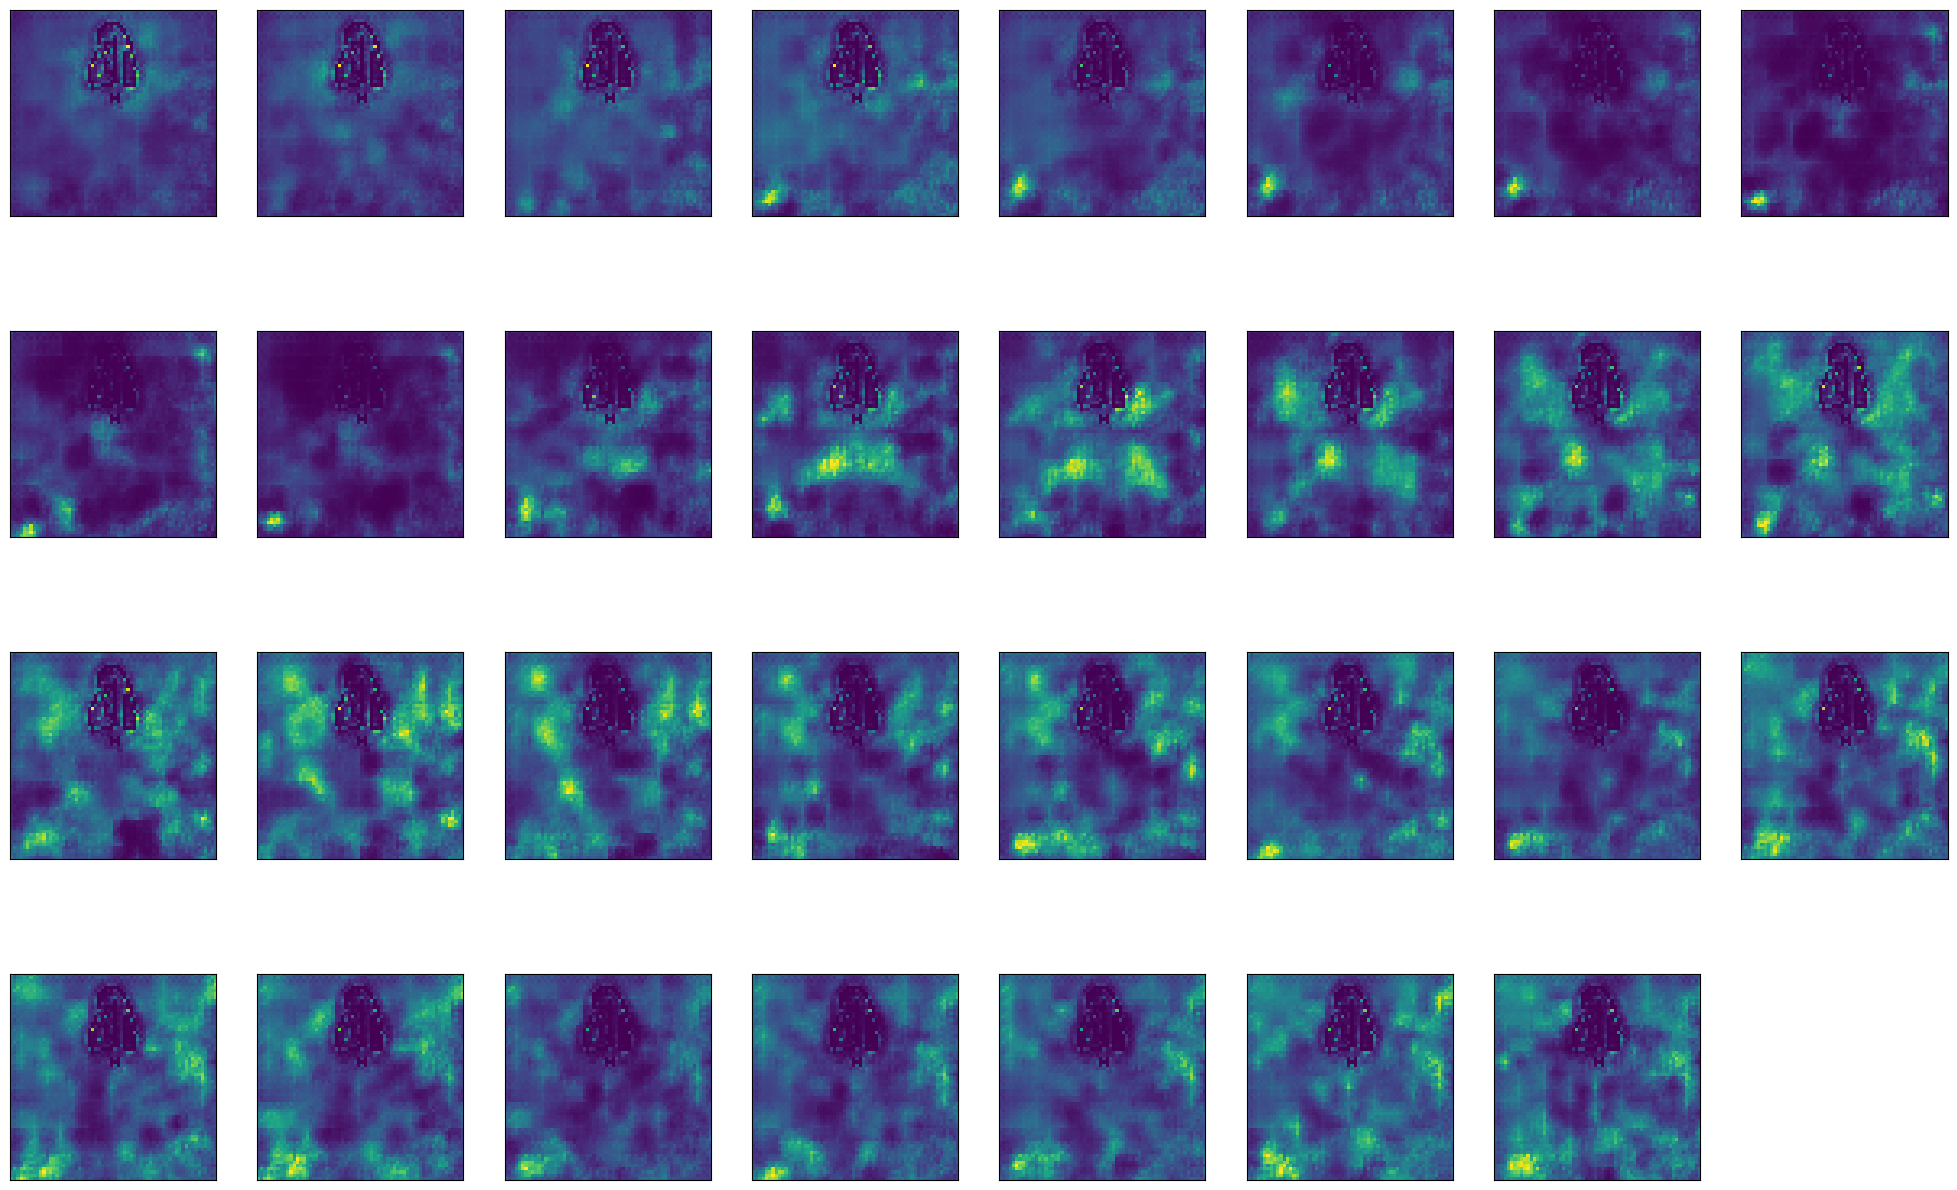

In [38]:
show_images(reconstructed_samples_full[n])

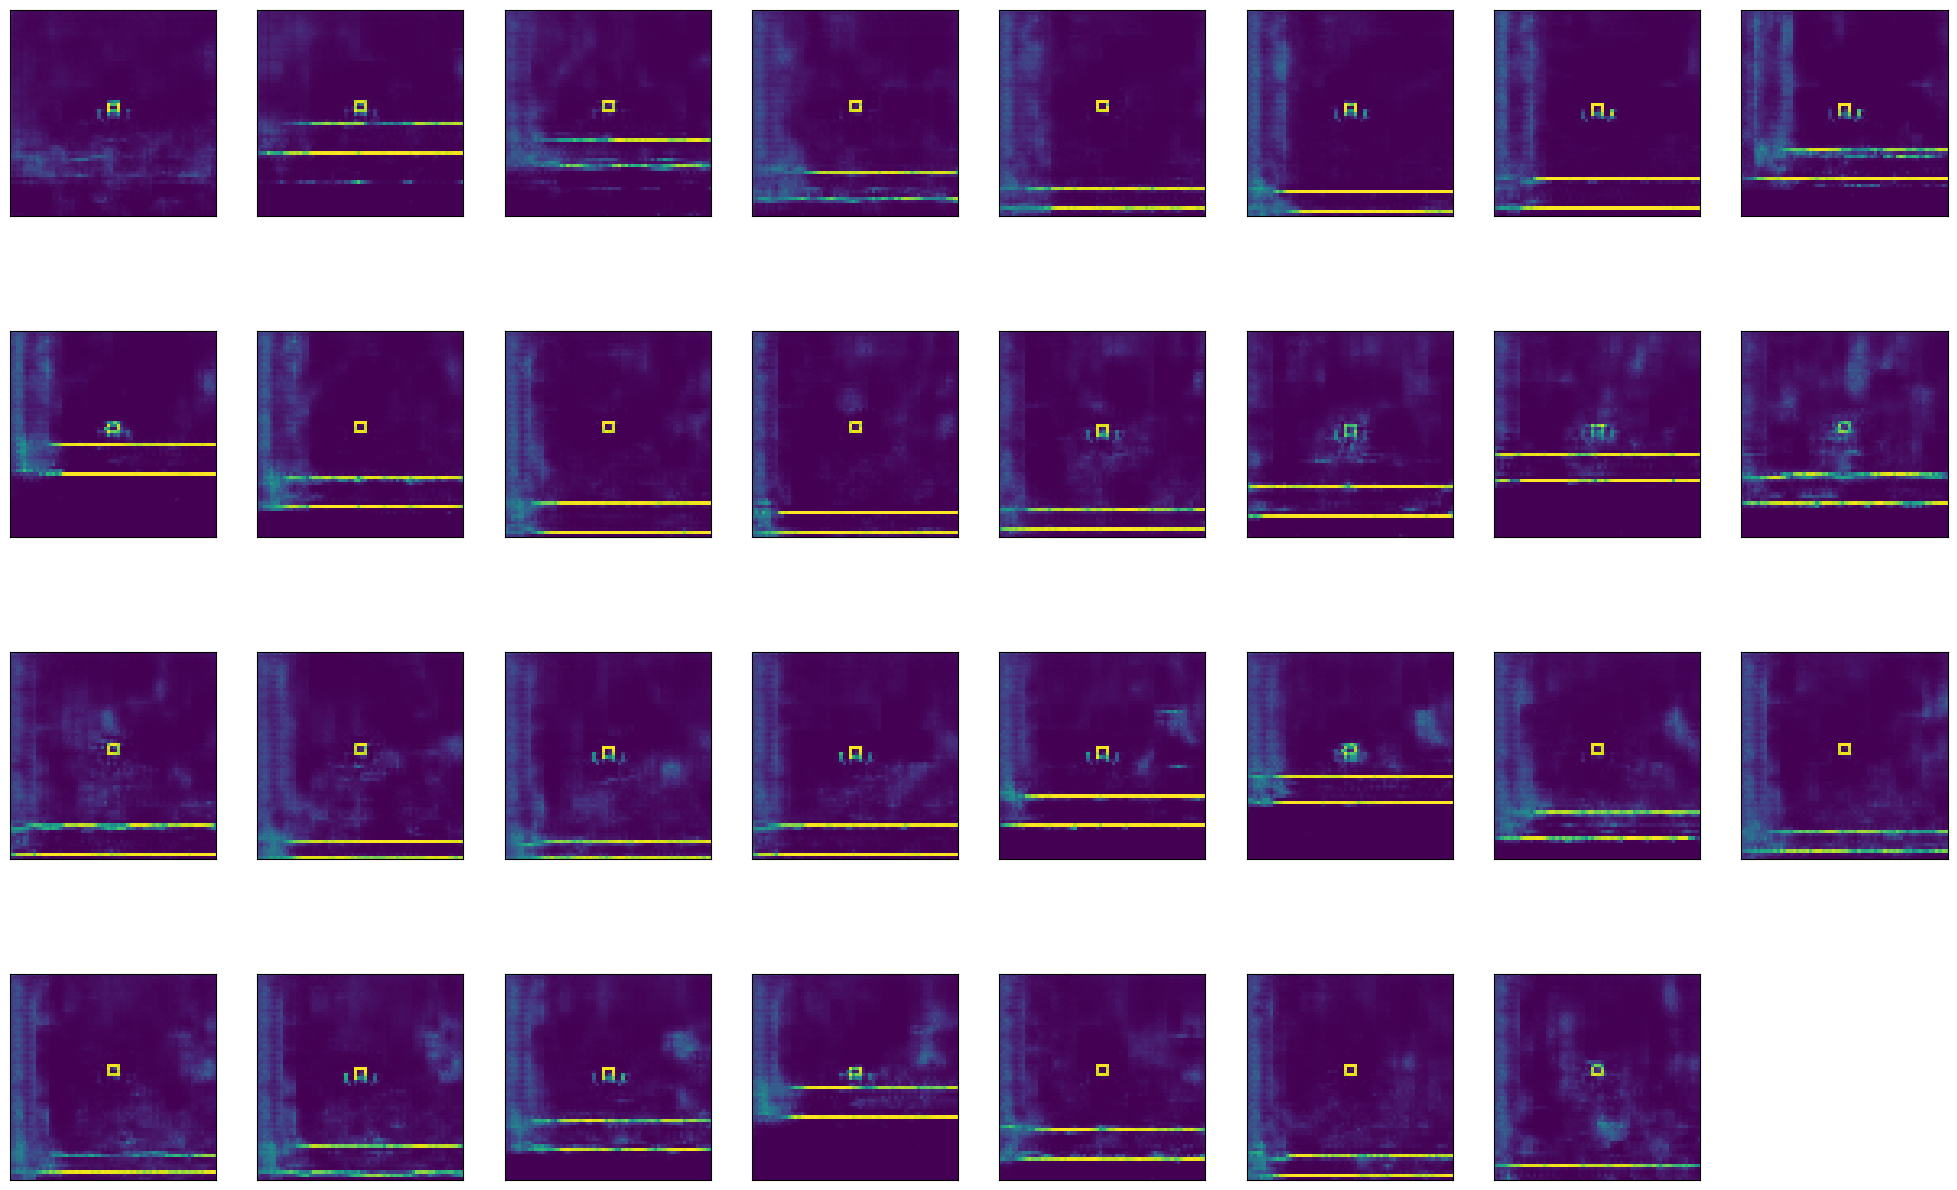

In [39]:
show_images(reconstructed_samples_part[n])

In [21]:
(decoder_debug(agent.posteriors_debug, agent.determenistics_debug).log_prob(pixel_normalization(torch.Tensor(sample)))/64/64).mean()

tensor(-46.9651, device='cuda:7', grad_fn=<MeanBackward0>)

In [27]:
obs_sample = dataset.observations[230:270,2]

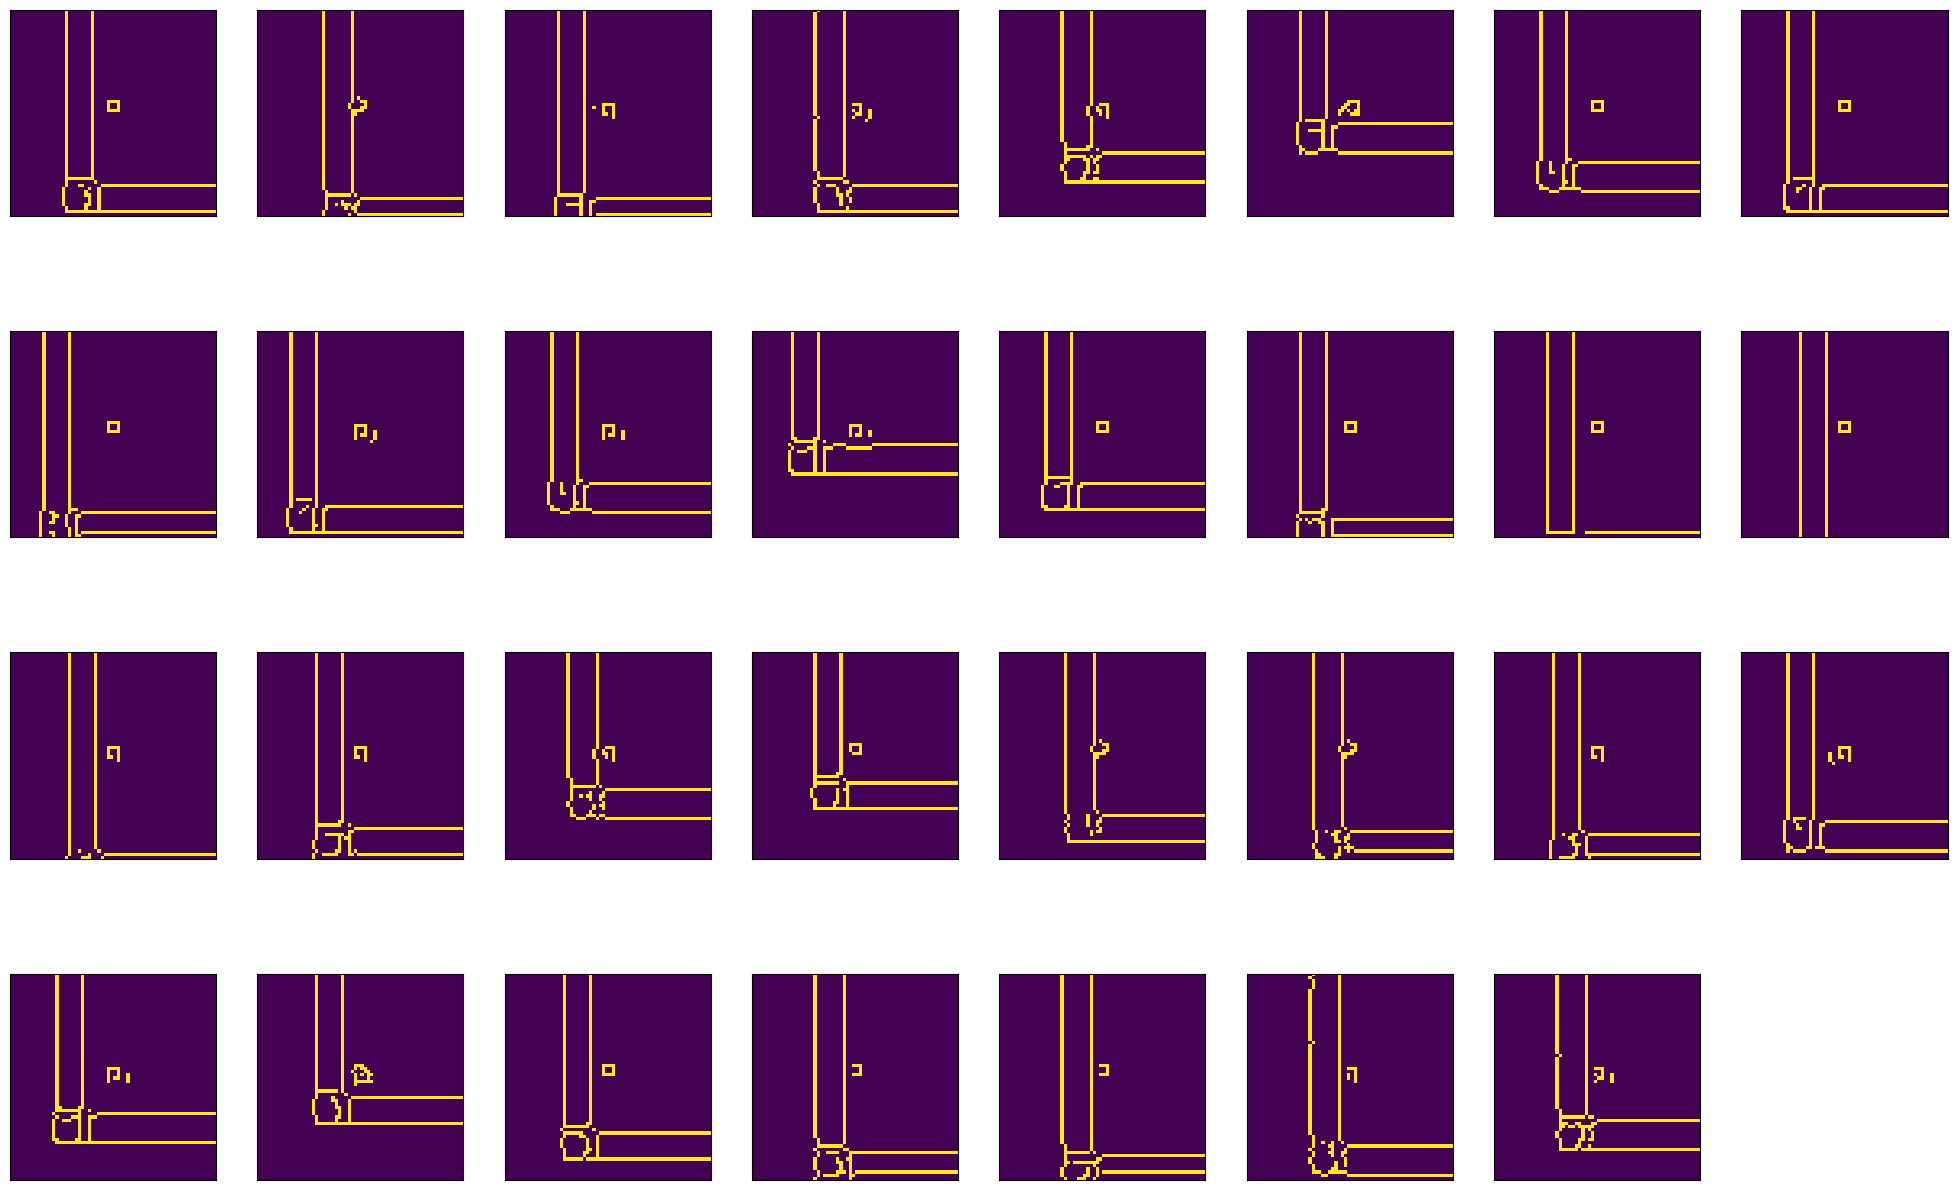

In [28]:
show_images(obs_sample)